In [2]:
from gluefactory.utils.experiments import load_experiment
from torchvision.transforms import Resize
from gluefactory.models.lines.deeplsd import DeepLSD
from gluefactory.models.extractors.superpoint_open import SuperPoint
from gluefactory.models.extractors.jpldd.joint_point_line_extractor import JointPointLineDetectorDescriptor
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import flow_vis
import os
import h5py

In [3]:
def get_flow_vis(df, ang, line_neighborhood=5):
    norm = line_neighborhood + 1 - np.clip(df, 0, line_neighborhood)
    flow_uv = np.stack([norm * np.cos(ang), norm * np.sin(ang)], axis=-1)
    flow_img = flow_vis.flow_to_color(flow_uv, convert_to_bgr=False)
    return flow_img

def numpy_image_to_torch(image):
    """Normalize the image tensor and reorder the dimensions."""
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW
    elif image.ndim == 2:
        image = image[None]  # add channel axis
    else:
        raise ValueError(f"Not an image: {image.shape}")
    return torch.tensor(image / 255.0, dtype=torch.float)

### Load Model

In [47]:
model_conf = {
    "name": "jpldd.joint_point_line_extractor",
    "model_name": "aliked-n16",
    "nms_radius": 4,
    "max_num_keypoints": 500,  # setting for training, for eval: -1
    "detection_threshold": -1,
    "pretrained": True,
    "timeit": False,  # override timeit: False from BaseModel
    "train_descriptors": {
        "do": False,  # if train is True, initialize ALIKED Light model form OTF Descriptor GT
        "device": None # device to house the lightweight ALIKED model
    }
}
#jpldd_model = load_experiment("../rk_jpldd_02/checkpoint_best.tar", model_conf)
jpldd_model = JointPointLineDetectorDescriptor(model_conf)

Load pretrained weights for aliked parts...


In [49]:
# DeepLSD Config
conf_lines = {
    "min_length": 15,
    "max_num_lines": None,
    "force_num_lines": False,
    "model_conf": {
        "detect_lines": False,
        "line_detection_params": {
            "merge": False,
            "grad_nfa": True,
            "filtering": "normal",
            "grad_thresh": 3.0,
        },
    }
}

# Superpoint Config
sp_conf = {
    "max_num_keypoints": 500, # None
    "nms_radius": 4,
    "detection_threshold": -1, #0.005,
    "remove_borders": 4,
    "descriptor_dim": 256,
    "channels": [64, 64, 128, 128, 256],
    "dense_outputs": None,
    "weights": None,  # local path of pretrained weights
}
deeplsd_model = DeepLSD(conf_lines)
superpoint_model = SuperPoint(sp_conf)
deeplsd_model.eval()

size = (800,800)
resize_func = Resize(size)


# Read image
SAMPLE_IMAGES = [
    "../data/minidepth/images/5007/00045.jpg",
    "../data/minidepth/images/5012/00052.jpg"
]
image_path = SAMPLE_IMAGES[0]

img = cv2.resize(cv2.imread(image_path),size)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_torch = numpy_image_to_torch(img)
img_torch = img_torch.unsqueeze(0)

# Run Forward passes on all models
with torch.no_grad():
    output_superpoint = superpoint_model({"image": img_torch})
    output_jpldd = jpldd_model({"image": img_torch})
    output_deeplsd = deeplsd_model.forward_ha({"image": img_torch})
distance_field_jpldd = torch.exp(-output_jpldd["deeplsd_line_distancefield"][0])*5
#distance_field_jpldd = output_jpldd["deeplsd_line_distancefield"][0]
angle_field_jpldd = output_jpldd["deeplsd_line_anglefield"][0]*torch.pi
distance_field_deeplsd = output_deeplsd["df"][0]
angle_field_deeplsd = output_deeplsd["line_level"][0]


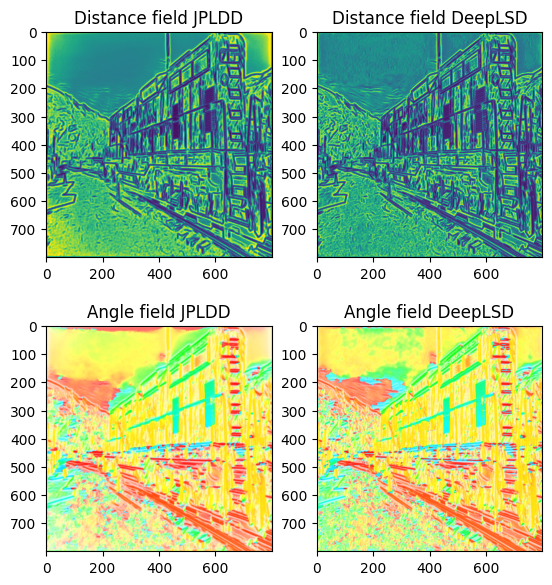

In [44]:
f, axarr = plt.subplots(2,2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0][0].imshow(distance_field_jpldd)
axarr[0][0].set_title("Distance field JPLDD")
axarr[1][0].imshow(get_flow_vis(distance_field_jpldd,angle_field_jpldd))
axarr[1][0].set_title("Angle field JPLDD")
axarr[0][1].imshow(distance_field_deeplsd)
axarr[0][1].set_title("Distance field DeepLSD")
axarr[1][1].imshow(get_flow_vis(distance_field_deeplsd,angle_field_deeplsd))
axarr[1][1].set_title("Angle field DeepLSD")
f.set_figheight(7)

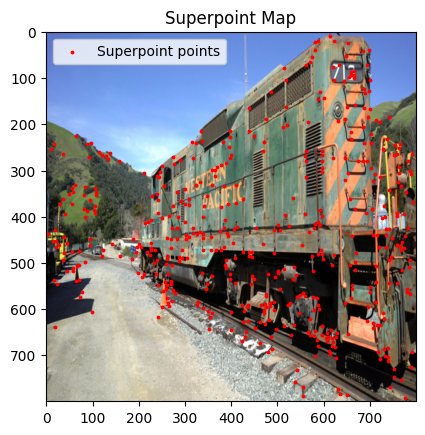

In [45]:
superpoint_points = output_superpoint["keypoints"][0].t()
# superpoint_map = output_superpoint["raw_scores"][0]
plt.imshow(img_rgb)

plt.title("Superpoint Map")
plt.scatter(superpoint_points[0],superpoint_points[1],s=3,label="Superpoint points", color="red")
plt.legend()
plt.show()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


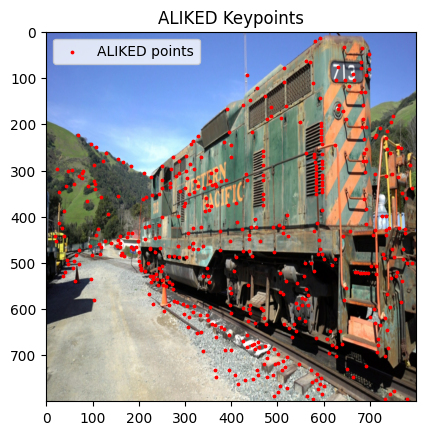

In [51]:
# JPLDD
kp_junction_map = output_jpldd["keypoint_and_junction_score_map"][0]
keypoints = output_jpldd["keypoints"][0].T

flat_indices = np.argpartition(kp_junction_map,-2000,axis=None)[-2000:]
mask = np.unravel_index(flat_indices,kp_junction_map.shape)
probs = kp_junction_map[mask]
pred = np.array(mask)
plt.imshow(img_rgb)

#plt.title("JPLDD Keypoints")
plt.title("ALIKED Keypoints")
#plt.scatter(pred[1],pred[0],s=3,label="JPLDD points")
plt.scatter(keypoints[0],keypoints[1],s=3,label="ALIKED points", color="red")
plt.legend()
plt.show()

In [ ]:
    # Open the HDF5 file and read the heatmap
    with h5py.File(filelist[i], 'r') as f:
        heatmap_data = np.array(f['superpoint_heatmap'])
heatmap_data = np.nan_to_num(heatmap_data)
print(heatmap_data)
plt.imshow(heatmap_data)
plt.title("Superpoint Ground Truth Heatmap")